In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
# Define the coRNNCell
class coRNNCell(nn.Module):
    def __init__(self, n_inp, n_hid, dt, gamma, epsilon):
        super(coRNNCell, self).__init__()
        self.dt = dt
        self.gamma = gamma
        self.epsilon = epsilon
        self.i2h = nn.Linear(n_inp + n_hid + n_hid, n_hid)

    def forward(self, x, hy, hz):
        hz = hz + self.dt * (torch.tanh(self.i2h(torch.cat((x, hz, hy), 1)))
                             - self.gamma * hy - self.epsilon * hz)
        hy = hy + self.dt * hz

        return hy, hz

# Define the coRNN model
class coRNN(nn.Module):
    def __init__(self, n_inp, n_hid, n_out, dt, gamma, epsilon):
        super(coRNN, self).__init__()
        self.n_hid = n_hid
        self.cell = coRNNCell(n_inp, n_hid, dt, gamma, epsilon)
        self.readout = nn.Linear(n_hid, n_out)

    def forward(self, x):
        hy = torch.zeros(x.size(1), self.n_hid)
        hz = torch.zeros(x.size(1), self.n_hid)

        for t in range(x.size(0)):
            hy, hz = self.cell(x[t], hy, hz)
        output = self.readout(hy)

        return output


### PINN data importing

In [2]:
# Load the .mat file
mat_data = scipy.io.loadmat('burg.mat')

# Access the variables stored in the .mat file
# The variable names in the .mat file become keys in the loaded dictionary
x = mat_data['x']
t = mat_data['t']
u = mat_data['u1']



### Exact Solution data importing

x size (256, 1)
t size (100, 1)
u size (256, 100)


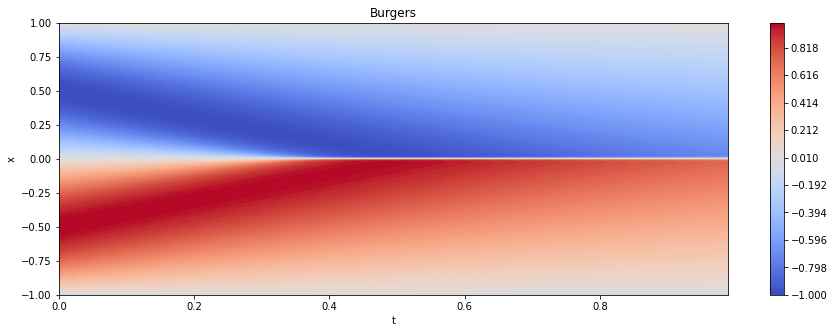

In [3]:
# importing data

import torch
import torch.nn as nn
import numpy as np
import time
import scipy.io

# Load the .mat file
mat_data = scipy.io.loadmat('burgers_shock.mat')

# Access the variables stored in the .mat file
# The variable names in the .mat file become keys in the loaded dictionary
x = mat_data['x']
t = mat_data['t']
u_1 = mat_data['usol']

#Use the loaded variables as needed
print("x size", x.shape)
print("t size", t.shape)
print("u size", u.shape)

X, T = np.meshgrid(x, t)
# Define custom color levels
c_levels = np.linspace(np.min(u_1), np.max(u_1), 100)

# Plot the contour
plt.figure(figsize=(15, 5))
plt.contourf(T, X, u_1.T, levels=c_levels, cmap='coolwarm')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Burgers')
plt.colorbar()  # Add a colorbar for the contour levels
plt.show()

In [4]:
# Toy problem data
input_size = 256
hidden_size = 32
output_size = 256
sequence_length = 79
batch_size = 1
num_epochs = 20000


# Set random seed for reproducibility
#torch.manual_seed(42)



input_data = u[:,0:79]
target_data = u[:,1:80]

test_data = u[:,79]
#test_target = u[:,80:100]


# Convert data to tensors
input_tensor = torch.tensor(input_data.T).view(batch_size, sequence_length, input_size).float()
target_tensor = torch.tensor(target_data.T).view(batch_size, sequence_length, output_size).float()

# Convert test data to tensors
test_tensor = torch.tensor(test_data.T).view(batch_size, 1, input_size).float()
#test_target_tensor = torch.tensor(test_target.T).view(batch_size, 20, output_size).float()

# Create coRNN instance
cornn = coRNN(input_size, hidden_size, output_size, dt=0.3, gamma=1.0, epsilon=0.01)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(cornn.parameters(), lr=0.001)

# Training loop
for epoch in range(num_epochs):
    # Forward pass
    output = cornn(input_tensor)
    loss = criterion(output, target_tensor)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch+1) % 10 == 0:
        print(f'Epoch: {epoch+1}/{num_epochs}, Loss: {loss.item():.8f}')


with torch.no_grad():
    prediction = cornn(test_tensor)

print(prediction.shape)

final_time_output = prediction[-1, :]
print(final_time_output.shape)

final_out = final_time_output.detach().numpy().reshape(-1,1)
final_true = u[:,-1].reshape(-1,1)



/data/localhome/tkapoor/.local/lib/python3.8/site-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([1, 79, 256])) that is different to the input size (torch.Size([79, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 10/20000, Loss: 0.38522387
Epoch: 20/20000, Loss: 0.34270805
Epoch: 30/20000, Loss: 0.30306086
Epoch: 40/20000, Loss: 0.26765296
Epoch: 50/20000, Loss: 0.23646106
Epoch: 60/20000, Loss: 0.20908652
Epoch: 70/20000, Loss: 0.18507674
Epoch: 80/20000, Loss: 0.16401480
Epoch: 90/20000, Loss: 0.14553864
Epoch: 100/20000, Loss: 0.12933798
Epoch: 110/20000, Loss: 0.11514545
Epoch: 120/20000, Loss: 0.10272832
Epoch: 130/20000, Loss: 0.09188181
Epoch: 140/20000, Loss: 0.08242445
Epoch: 150/20000, Loss: 0.07419468
Epoch: 160/20000, Loss: 0.06704825
Epoch: 170/20000, Loss: 0.06085623
Epoch: 180/20000, Loss: 0.05550340
Epoch: 190/20000, Loss: 0.05088682
Epoch: 200/20000, Loss: 0.04691470
Epoch: 210/20000, Loss: 0.04350528
Epoch: 220/20000, Loss: 0.04058591
Epoch: 230/20000, Loss: 0.03809223
Epoch: 240/20000, Loss: 0.03596735
Epoch: 250/20000, Loss: 0.03416111
Epoch: 260/20000, Loss: 0.03262945
Epoch: 270/20000, Loss: 0.03133376
Epoch: 280/20000, Loss: 0.03024031
Epoch: 290/20000, Loss: 0.029

Epoch: 2320/20000, Loss: 0.00031628
Epoch: 2330/20000, Loss: 0.00031127
Epoch: 2340/20000, Loss: 0.00030636
Epoch: 2350/20000, Loss: 0.00030155
Epoch: 2360/20000, Loss: 0.00029684
Epoch: 2370/20000, Loss: 0.00029224
Epoch: 2380/20000, Loss: 0.00028772
Epoch: 2390/20000, Loss: 0.00028330
Epoch: 2400/20000, Loss: 0.00027897
Epoch: 2410/20000, Loss: 0.00027473
Epoch: 2420/20000, Loss: 0.00027057
Epoch: 2430/20000, Loss: 0.00026649
Epoch: 2440/20000, Loss: 0.00026249
Epoch: 2450/20000, Loss: 0.00025857
Epoch: 2460/20000, Loss: 0.00025472
Epoch: 2470/20000, Loss: 0.00025095
Epoch: 2480/20000, Loss: 0.00024724
Epoch: 2490/20000, Loss: 0.00024361
Epoch: 2500/20000, Loss: 0.00024004
Epoch: 2510/20000, Loss: 0.00023654
Epoch: 2520/20000, Loss: 0.00023310
Epoch: 2530/20000, Loss: 0.00022972
Epoch: 2540/20000, Loss: 0.00022641
Epoch: 2550/20000, Loss: 0.00022315
Epoch: 2560/20000, Loss: 0.00021995
Epoch: 2570/20000, Loss: 0.00021681
Epoch: 2580/20000, Loss: 0.00021372
Epoch: 2590/20000, Loss: 0.0

Epoch: 4640/20000, Loss: 0.00002282
Epoch: 4650/20000, Loss: 0.00002203
Epoch: 4660/20000, Loss: 0.00002168
Epoch: 4670/20000, Loss: 0.00002145
Epoch: 4680/20000, Loss: 0.00002126
Epoch: 4690/20000, Loss: 0.00002108
Epoch: 4700/20000, Loss: 0.00002090
Epoch: 4710/20000, Loss: 0.00002072
Epoch: 4720/20000, Loss: 0.00002054
Epoch: 4730/20000, Loss: 0.00002036
Epoch: 4740/20000, Loss: 0.00002019
Epoch: 4750/20000, Loss: 0.00002001
Epoch: 4760/20000, Loss: 0.00001984
Epoch: 4770/20000, Loss: 0.00001967
Epoch: 4780/20000, Loss: 0.00001951
Epoch: 4790/20000, Loss: 0.00001934
Epoch: 4800/20000, Loss: 0.00001918
Epoch: 4810/20000, Loss: 0.00001901
Epoch: 4820/20000, Loss: 0.00001885
Epoch: 4830/20000, Loss: 0.00001869
Epoch: 4840/20000, Loss: 0.00001853
Epoch: 4850/20000, Loss: 0.00001838
Epoch: 4860/20000, Loss: 0.00001822
Epoch: 4870/20000, Loss: 0.00001807
Epoch: 4880/20000, Loss: 0.00001885
Epoch: 4890/20000, Loss: 0.00001933
Epoch: 4900/20000, Loss: 0.00001789
Epoch: 4910/20000, Loss: 0.0

Epoch: 7070/20000, Loss: 0.00000360
Epoch: 7080/20000, Loss: 0.00000416
Epoch: 7090/20000, Loss: 0.00000374
Epoch: 7100/20000, Loss: 0.00000356
Epoch: 7110/20000, Loss: 0.00000351
Epoch: 7120/20000, Loss: 0.00000355
Epoch: 7130/20000, Loss: 0.00000511
Epoch: 7140/20000, Loss: 0.00000386
Epoch: 7150/20000, Loss: 0.00000375
Epoch: 7160/20000, Loss: 0.00000351
Epoch: 7170/20000, Loss: 0.00000340
Epoch: 7180/20000, Loss: 0.00000336
Epoch: 7190/20000, Loss: 0.00000333
Epoch: 7200/20000, Loss: 0.00000331
Epoch: 7210/20000, Loss: 0.00000328
Epoch: 7220/20000, Loss: 0.00000326
Epoch: 7230/20000, Loss: 0.00000324
Epoch: 7240/20000, Loss: 0.00000323
Epoch: 7250/20000, Loss: 0.00000367
Epoch: 7260/20000, Loss: 0.00000409
Epoch: 7270/20000, Loss: 0.00000318
Epoch: 7280/20000, Loss: 0.00000327
Epoch: 7290/20000, Loss: 0.00000319
Epoch: 7300/20000, Loss: 0.00000312
Epoch: 7310/20000, Loss: 0.00000308
Epoch: 7320/20000, Loss: 0.00000306
Epoch: 7330/20000, Loss: 0.00000304
Epoch: 7340/20000, Loss: 0.0

Epoch: 9520/20000, Loss: 0.00000095
Epoch: 9530/20000, Loss: 0.00000084
Epoch: 9540/20000, Loss: 0.00000083
Epoch: 9550/20000, Loss: 0.00000082
Epoch: 9560/20000, Loss: 0.00000087
Epoch: 9570/20000, Loss: 0.00000260
Epoch: 9580/20000, Loss: 0.00000121
Epoch: 9590/20000, Loss: 0.00000132
Epoch: 9600/20000, Loss: 0.00000092
Epoch: 9610/20000, Loss: 0.00000079
Epoch: 9620/20000, Loss: 0.00000079
Epoch: 9630/20000, Loss: 0.00000078
Epoch: 9640/20000, Loss: 0.00000078
Epoch: 9650/20000, Loss: 0.00000077
Epoch: 9660/20000, Loss: 0.00000077
Epoch: 9670/20000, Loss: 0.00000077
Epoch: 9680/20000, Loss: 0.00000076
Epoch: 9690/20000, Loss: 0.00000076
Epoch: 9700/20000, Loss: 0.00000077
Epoch: 9710/20000, Loss: 0.00000170
Epoch: 9720/20000, Loss: 0.00000078
Epoch: 9730/20000, Loss: 0.00000174
Epoch: 9740/20000, Loss: 0.00000076
Epoch: 9750/20000, Loss: 0.00000084
Epoch: 9760/20000, Loss: 0.00000074
Epoch: 9770/20000, Loss: 0.00000075
Epoch: 9780/20000, Loss: 0.00000072
Epoch: 9790/20000, Loss: 0.0

Epoch: 11870/20000, Loss: 0.00000029
Epoch: 11880/20000, Loss: 0.00000028
Epoch: 11890/20000, Loss: 0.00000028
Epoch: 11900/20000, Loss: 0.00000028
Epoch: 11910/20000, Loss: 0.00000028
Epoch: 11920/20000, Loss: 0.00000060
Epoch: 11930/20000, Loss: 0.00000054
Epoch: 11940/20000, Loss: 0.00000030
Epoch: 11950/20000, Loss: 0.00000033
Epoch: 11960/20000, Loss: 0.00000029
Epoch: 11970/20000, Loss: 0.00000049
Epoch: 11980/20000, Loss: 0.00000377
Epoch: 11990/20000, Loss: 0.00000131
Epoch: 12000/20000, Loss: 0.00000030
Epoch: 12010/20000, Loss: 0.00000033
Epoch: 12020/20000, Loss: 0.00000032
Epoch: 12030/20000, Loss: 0.00000029
Epoch: 12040/20000, Loss: 0.00000027
Epoch: 12050/20000, Loss: 0.00000027
Epoch: 12060/20000, Loss: 0.00000027
Epoch: 12070/20000, Loss: 0.00000026
Epoch: 12080/20000, Loss: 0.00000026
Epoch: 12090/20000, Loss: 0.00000026
Epoch: 12100/20000, Loss: 0.00000026
Epoch: 12110/20000, Loss: 0.00000034
Epoch: 12120/20000, Loss: 0.00000323
Epoch: 12130/20000, Loss: 0.00000176
E

Epoch: 14250/20000, Loss: 0.00000021
Epoch: 14260/20000, Loss: 0.00000021
Epoch: 14270/20000, Loss: 0.00000033
Epoch: 14280/20000, Loss: 0.00000147
Epoch: 14290/20000, Loss: 0.00000017
Epoch: 14300/20000, Loss: 0.00000021
Epoch: 14310/20000, Loss: 0.00000025
Epoch: 14320/20000, Loss: 0.00000021
Epoch: 14330/20000, Loss: 0.00000017
Epoch: 14340/20000, Loss: 0.00000017
Epoch: 14350/20000, Loss: 0.00000020
Epoch: 14360/20000, Loss: 0.00000046
Epoch: 14370/20000, Loss: 0.00000227
Epoch: 14380/20000, Loss: 0.00000078
Epoch: 14390/20000, Loss: 0.00000040
Epoch: 14400/20000, Loss: 0.00000025
Epoch: 14410/20000, Loss: 0.00000018
Epoch: 14420/20000, Loss: 0.00000017
Epoch: 14430/20000, Loss: 0.00000017
Epoch: 14440/20000, Loss: 0.00000017
Epoch: 14450/20000, Loss: 0.00000017
Epoch: 14460/20000, Loss: 0.00000017
Epoch: 14470/20000, Loss: 0.00000020
Epoch: 14480/20000, Loss: 0.00000255
Epoch: 14490/20000, Loss: 0.00000160
Epoch: 14500/20000, Loss: 0.00000041
Epoch: 14510/20000, Loss: 0.00000043
E

Epoch: 16600/20000, Loss: 0.00000146
Epoch: 16610/20000, Loss: 0.00000060
Epoch: 16620/20000, Loss: 0.00000027
Epoch: 16630/20000, Loss: 0.00000017
Epoch: 16640/20000, Loss: 0.00000015
Epoch: 16650/20000, Loss: 0.00000014
Epoch: 16660/20000, Loss: 0.00000014
Epoch: 16670/20000, Loss: 0.00000013
Epoch: 16680/20000, Loss: 0.00000013
Epoch: 16690/20000, Loss: 0.00000013
Epoch: 16700/20000, Loss: 0.00000013
Epoch: 16710/20000, Loss: 0.00000013
Epoch: 16720/20000, Loss: 0.00000013
Epoch: 16730/20000, Loss: 0.00000013
Epoch: 16740/20000, Loss: 0.00000013
Epoch: 16750/20000, Loss: 0.00000013
Epoch: 16760/20000, Loss: 0.00000013
Epoch: 16770/20000, Loss: 0.00000013
Epoch: 16780/20000, Loss: 0.00000013
Epoch: 16790/20000, Loss: 0.00000013
Epoch: 16800/20000, Loss: 0.00000013
Epoch: 16810/20000, Loss: 0.00000013
Epoch: 16820/20000, Loss: 0.00000015
Epoch: 16830/20000, Loss: 0.00000191
Epoch: 16840/20000, Loss: 0.00000063
Epoch: 16850/20000, Loss: 0.00000048
Epoch: 16860/20000, Loss: 0.00000028
E

Epoch: 18940/20000, Loss: 0.00000017
Epoch: 18950/20000, Loss: 0.00000060
Epoch: 18960/20000, Loss: 0.00000023
Epoch: 18970/20000, Loss: 0.00000017
Epoch: 18980/20000, Loss: 0.00000012
Epoch: 18990/20000, Loss: 0.00000011
Epoch: 19000/20000, Loss: 0.00000012
Epoch: 19010/20000, Loss: 0.00000035
Epoch: 19020/20000, Loss: 0.00000253
Epoch: 19030/20000, Loss: 0.00000088
Epoch: 19040/20000, Loss: 0.00000033
Epoch: 19050/20000, Loss: 0.00000016
Epoch: 19060/20000, Loss: 0.00000013
Epoch: 19070/20000, Loss: 0.00000012
Epoch: 19080/20000, Loss: 0.00000011
Epoch: 19090/20000, Loss: 0.00000011
Epoch: 19100/20000, Loss: 0.00000012
Epoch: 19110/20000, Loss: 0.00000059
Epoch: 19120/20000, Loss: 0.00000019
Epoch: 19130/20000, Loss: 0.00000020
Epoch: 19140/20000, Loss: 0.00000018
Epoch: 19150/20000, Loss: 0.00000166
Epoch: 19160/20000, Loss: 0.00000042
Epoch: 19170/20000, Loss: 0.00000073
Epoch: 19180/20000, Loss: 0.00000012
Epoch: 19190/20000, Loss: 0.00000016
Epoch: 19200/20000, Loss: 0.00000013
E

In [5]:
print(test_tensor.shape)
prediction_tensor = torch.zeros(1, 20, 256).float()
print(prediction_tensor.shape)

torch.Size([1, 1, 256])
torch.Size([1, 20, 256])


In [6]:
with torch.no_grad():
    prediction = cornn(test_tensor)
    prediction = prediction.view(1, 1, 256).float()
    prediction_tensor[:, 0, :] = prediction
    for i in range(19):
        prediction = cornn(prediction)
        prediction = prediction.view(1, 1, 256).float()
        prediction_tensor[:, i+1, :] = prediction

In [7]:
# Exact Solution

u_test = u_1.T
u_test_full = u_test[80:100, :]

In [8]:
prediction.shape

torch.Size([1, 1, 256])

In [9]:
u_test_full.shape

(20, 256)

### L2 norm

In [10]:
# Extrapolation

k1 = ( prediction_tensor - u_test_full)**2
u_test_full_tensor = torch.tensor(u_test_full**2)
u_test_full_tensor.shape

torch.Size([20, 256])

In [11]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean(k1)/ torch.mean(u_test_full_tensor)

print("Relative Error Test: ", relative_error_test.item(), "%")

Relative Error Test:  0.30029040995473627 %


In [12]:
2+

SyntaxError: invalid syntax (4209523232.py, line 1)

### Max absolute error

In [ ]:
R_abs = torch.max(torch.abs(prediction_tensor - u_test_full))
print(R_abs)

### Explained variance score

In [ ]:
import torch

a = prediction_tensor
b = u_test_full
# Assuming 'a' is your predicted values (model's predictions) and 'b' is the true values (ground truth)
# Make sure 'a' and 'b' are PyTorch tensors
a = torch.tensor(a)
b = torch.tensor(b)
# Calculate the mean of 'b'
mean_b = torch.mean(b)

# Calculate the Explained Variance Score
numerator = torch.var(b - a)  # Variance of the differences between 'b' and 'a'
denominator = torch.var(b)    # Variance of 'b'
evs = 1 - numerator / denominator

print("Explained Variance Score:", evs.item())

### Mean absolute error

In [ ]:
# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean(torch.abs(prediction_tensor - u_test_full))

print("Relative Error Test: ", relative_error_test, "%")

In [ ]:
print(prediction_tensor.shape)
prediction_tensor = torch.squeeze(prediction_tensor)
prediction_tensor.shape

### Ploting at snapshot

In [ ]:
plt.rcParams['figure.figsize'] = [10, 4]

from matplotlib.font_manager import FontProperties
plt.rcParams['axes.unicode_minus'] = False
font_path = 'times-new-roman.ttf'
custom_font = FontProperties(fname=font_path)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create the figure and axis objects with reduced width
fig, ax = plt.subplots(figsize=(5, 5))  # You can adjust the width (7 inches) and height (5 inches) as needed




final_time_output = prediction_tensor[3, :]
final_out = final_time_output.detach().numpy().reshape(-1, 1)
final_true = u_1[:, 83].reshape(-1, 1)

# Plot the data with red and blue lines, one with dotted and one with solid style
ax.plot(x, final_out, color='red', linestyle='dotted', linewidth=12, label='Prediction')
ax.plot(x, final_true, color='blue', linestyle='solid', linewidth=7, label='True')


# Set the axis labels with bold font weight
ax.set_xlabel(r"${x}$", fontsize=26, color='black', fontdict={'weight': 'bold'})
ax.set_ylabel(r"${u(x, t)}$", fontsize=26, color='black', fontdict={'weight': 'bold'})

# Set the title with bold font weight
ax.set_title(r"${t = 0.83}$", fontsize=26, color='black', fontweight='bold')

# Set the number of ticks for x-axis and y-axis to 3
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])

# Set tick labels fontweight to bold and increase font size
ax.tick_params(axis='both', which='major', labelsize=20, width=2, length=10)

# # Set the fontweight for tick labels to bold
# for tick in ax.get_xticklabels() + ax.get_yticklabels():
#     tick.set_weight('bold')

# Set the spines linewidth to bold
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Set the legend
# ax.legend()

plt.savefig('coRNN_0.83_20.pdf', dpi=500, bbox_inches="tight")
#plt.savefig('lem_0.83_20.png', dpi=500, bbox_inches="tight")
# Show the plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Create the figure and axis objects with reduced width
fig, ax = plt.subplots(figsize=(5, 5))  # You can adjust the width (7 inches) and height (5 inches) as needed



final_time_output = prediction_tensor[-2, :]
final_out = final_time_output.detach().numpy().reshape(-1, 1)
final_true = u_1[:, -2].reshape(-1, 1)

# Plot the data with red and blue lines, one with dotted and one with solid style
ax.plot(x, final_out, color='red', linestyle='dotted', linewidth=12, label='Prediction')
ax.plot(x, final_true, color='blue', linestyle='solid', linewidth=7, label='True')


# Set the axis labels with bold font weight
ax.set_xlabel(r"${x}$", fontsize=26, color='black', fontdict={'weight': 'bold'})
ax.set_ylabel(r"${u(x, t)}$", fontsize=26, color='black', fontdict={'weight': 'bold'})

# Set the title with bold font weight
ax.set_title(r"${t = 0.98}$", fontsize=26, color='black', fontweight='bold')

# Set the number of ticks for x-axis and y-axis to 3
ax.set_xticks([-1, 0, 1])
ax.set_yticks([-1, 0, 1])

# Set tick labels fontweight to bold and increase font size
ax.tick_params(axis='both', which='major', labelsize=20, width=2, length=10)

# # Set the fontweight for tick labels to bold
# for tick in ax.get_xticklabels() + ax.get_yticklabels():
#     tick.set_weight('bold')

# Set the spines linewidth to bold
ax.spines['top'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)

# Set the legend
# ax.legend()

plt.savefig('coRNN_0.98_20.pdf', dpi=500, bbox_inches="tight")
#plt.savefig('lem_0.98_20.png', dpi=500, bbox_inches="tight")
# Show the plot
plt.show()


### contour plot

In [ ]:
print(input_tensor.shape)

In [ ]:
print(prediction_tensor.shape)
prediction_tensor = torch.squeeze(prediction_tensor)
input_tensor = torch.squeeze(input_tensor)

conc_u = torch.squeeze(input_tensor)
concatenated_tensor = torch.cat((conc_u, prediction_tensor), dim=0)

x1 = np.linspace(-1, 1, 256)
t1 = np.linspace(0, 1, 99)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator

# Assuming you have defined concatenated_tensor as a PyTorch tensor
# concatenated_tensor = torch.cat((tensor1, tensor2), dim=0)

# Convert concatenated_tensor to a NumPy array
concatenated_array = concatenated_tensor.numpy()

# Define custom color levels
x = np.linspace(-1, 1, concatenated_array.shape[1])  # Replace 0 and 1 with your actual x range
t = np.linspace(0, 1, concatenated_array.shape[0])  # Replace 0 and 1 with your actual t range
X, T = np.meshgrid(x, t1)

# Define custom color levels using the minimum and maximum from the NumPy array
c_levels = np.linspace(np.min(concatenated_array), np.max(concatenated_array), 400)

# Plot the contour with interpolated data
plt.figure(figsize=(20, 5))
plt.pcolormesh(T, X, concatenated_array, shading='auto', cmap='coolwarm')

# Set the fontweight for axis labels to regular (not bold)
plt.xlabel("$t$", fontsize=26)
plt.ylabel("$x$", fontsize=26)
plt.title("$u(x, t)$", fontsize=26)

# Set tick labels fontweight to regular (not bold) and increase font size
plt.tick_params(axis='both', which='major', labelsize=20, width=3, length=10)

# Set the fontweight for tick labels to regular (not bold)
for tick in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
    tick.set_weight('normal')

# Set the number of ticks for x-axis and y-axis to 5
num_ticks = 5
x_ticks = np.linspace(np.min(T), np.max(T), num_ticks)
y_ticks = np.linspace(np.min(X), np.max(X), num_ticks)

plt.gca().xaxis.set_major_locator(FixedLocator(x_ticks))
plt.gca().yaxis.set_major_locator(FixedLocator(y_ticks))

cbar1 = plt.colorbar()
# Set the number of ticks for the color bar with uniformly distributed numbers
num_ticks = 5
c_ticks = np.linspace(np.min(concatenated_array), np.max(concatenated_array), num_ticks)
cbar1.set_ticks(c_ticks)

# Set the fontweight and fontsize for color bar tick labels
for t in cbar1.ax.get_yticklabels():
    t.set_weight('normal')
    t.set_fontsize(26)  # Increase the font size for color bar tick labels

# Increase the size of numbers on axis and color bar
plt.xticks(fontsize=26)
plt.yticks(fontsize=26)

# Increase the tick size and width of the color bar
cbar1.ax.tick_params(axis='both', which='major', labelsize=30, width=3,  length=10)

# Add a dotted line at t = 0.8
plt.axvline(x=0.8, color='black', linestyle='dotted', linewidth=5)

#plt.savefig('Contour_LEM_20.pdf', dpi=500, bbox_inches="tight")
plt.savefig('contour_coRNN_20.jpeg', dpi=500, bbox_inches="tight")
# Show the plot
plt.show()
